1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

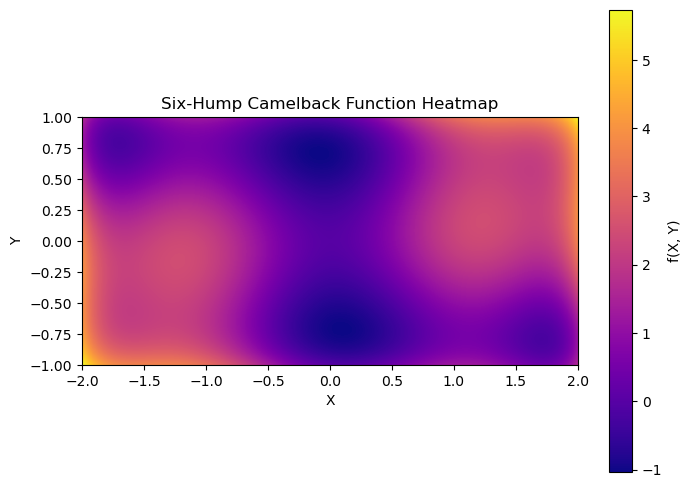

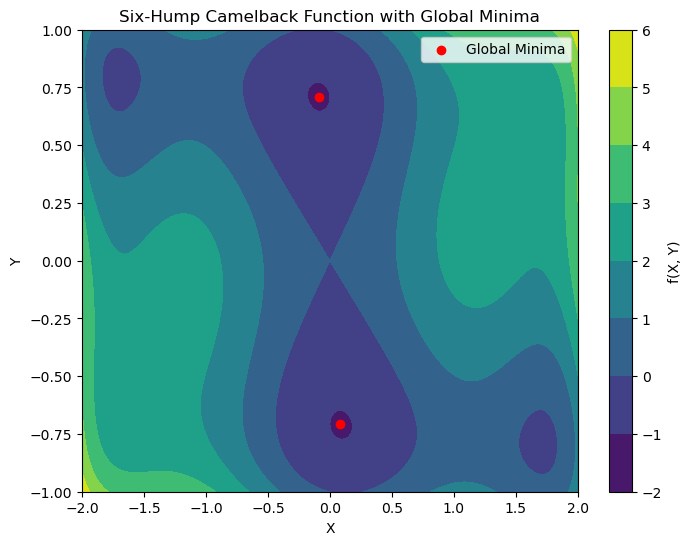

Global Minimum Point: (0.08521303258145352, -0.7085427135678393)
Function Value at Minimum: -1.0314260977136818
Global Minimum Point: (-0.08521303258145374, 0.7085427135678393)
Function Value at Minimum: -1.0314260977136818


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the six-hump camelback function
def six_hump_camelback(x):
    return (4 - 2.1 * x[0]**2 + (x[0]**4) / 3) * x[0]**2 + x[0] * x[1] + (-4 + 4 * x[1]**2) * x[1]**2

# Define the bounds for x and y
bounds = [(-2, 2), (-1, 1)]
# Generate a meshgrid for visualization
x_values = np.linspace(-2, 2, 400)
y_values = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x_values, y_values)
Z = six_hump_camelback([X, Y])

# Plot the heatmap using imshow
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='plasma')
plt.colorbar(label='f(X, Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Six-Hump Camelback Function Heatmap')


# Definisci la funzione six-hump camelback
def six_hump_camelback(x, y):
    return (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2

# Genera una griglia di punti
x_values = np.linspace(-2, 2, 400)
y_values = np.linspace(-1, 1, 200)

# Calcola i valori della funzione sulla griglia
Z = np.zeros((len(y_values), len(x_values)))
for i, y in enumerate(y_values):
    for j, x in enumerate(x_values):
        Z[i, j] = six_hump_camelback(x, y)

# Trova i minimi della funzione sulla griglia
minima_points = np.argwhere(Z == np.min(Z))
minima_values = [Z[tuple(point)] for point in minima_points]

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z)#, levels=30)#,cmap='viridis')
plt.colorbar(contour, label='f(X, Y)')
plt.scatter(x_values[minima_points[:, 1]], y_values[minima_points[:, 0]], c='red', marker='o', label='Global Minima')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Six-Hump Camelback Function with Global Minima')
plt.legend()
plt.show()

# Stampa i minimi globali
for point, value in zip(minima_points, minima_values):
    print(f"Global Minimum Point: ({x_values[point[1]]}, {y_values[point[0]]})")
    print(f"Function Value at Minimum: {value}")


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

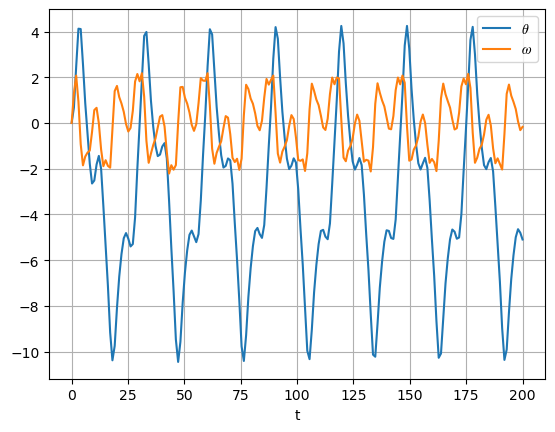

In [6]:
import math
from scipy.integrate import odeint

P=(0,0)
l = 10
Q = 2
d = 1.5
om = 0.65
t = np.linspace(0, 200, 200)

def dev(X, t, l,Q, d, omega):
    return (X[1], (-1/Q)*X[1]+(9.81/l)*np.sin(X[0])+d*np.cos(omega*t))
X = odeint(dev, P, t, args=(l,Q, d, om))

plt.figure()
plt.plot(t, X[:, 0], label="$𝜃$")
plt.plot(t, X[:, 1], label="$𝜔$")

plt.xlabel('t')
plt.legend(loc='best')
plt.grid('on')
plt.show()



3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

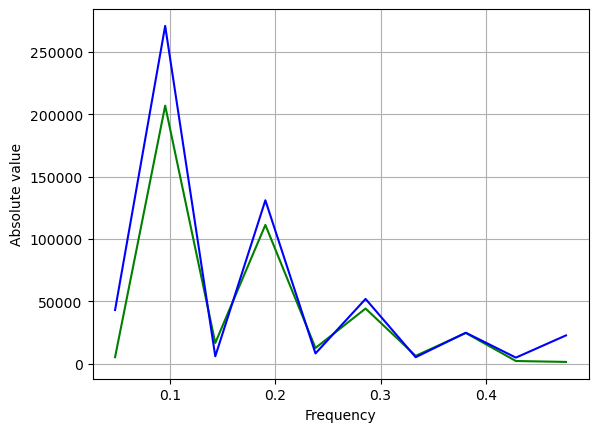

The periodicity hares:  10.5
The periodicity lynxes:  10.5


In [7]:
from scipy import fftpack
import csv
import pandas as pd

filepath = "data\populations.txt"
df = pd.read_csv(filepath, sep='\t')
year=df['# year']
population=df.iloc[:, [1,2]]
ft_df= np.abs(fftpack.fft(population, axis=0))
#l_df
l_ft=ft_df[:,[0]]
h_ft=ft_df[:,[1]]

freq= fftpack.fftfreq(df.shape[0],d=1)
mask=np.where(freq>0)
freq_m=freq[mask]
h_ft = h_ft[mask]
l_ft = l_ft[mask]


plt.figure()
plt.plot(freq_m, h_ft, color='green')
plt.plot(freq_m, l_ft, color='blue')
plt.grid('True')
plt.xlabel('Frequency')
plt.ylabel('Absolute value')
plt.show()
main_f_h = freq_m[h_ft.argmax()]
main_f_l = freq_m[l_ft.argmax()]
print('The periodicity hares: ', 1/main_f_h)
print('The periodicity lynxes: ', 1/main_f_l)

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'New Image')

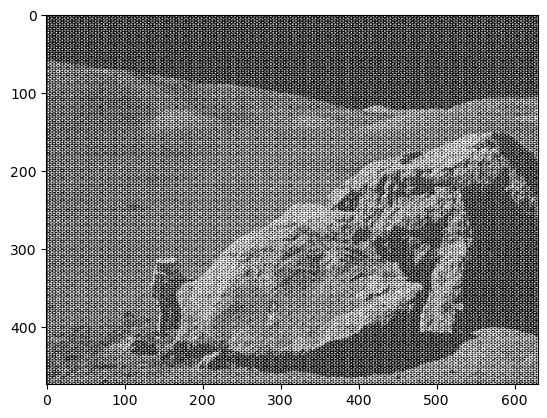

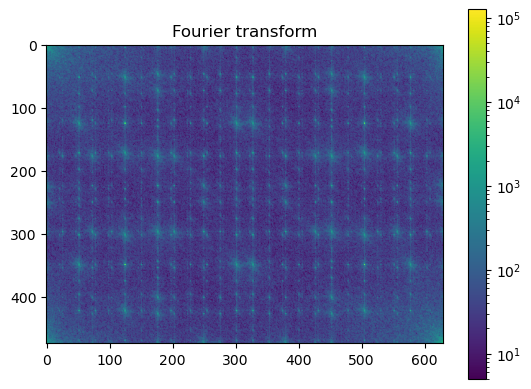

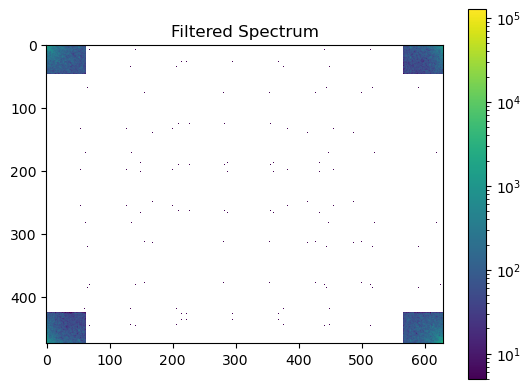

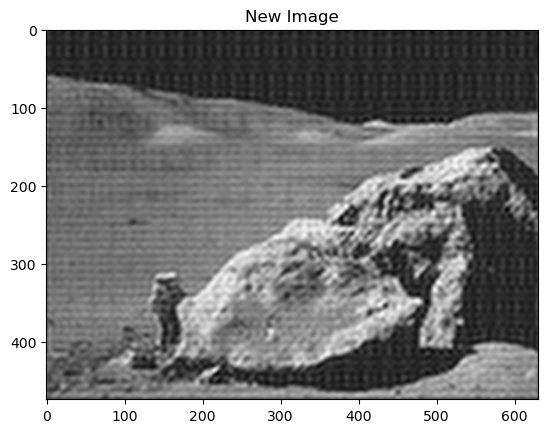

In [8]:
from matplotlib.colors import LogNorm
img=plt.imread("images/moonlanding.png")
plt.imshow(img,plt.cm.gray)
img_fft = fftpack.fft2(img)

plt.figure()
plt.imshow(np.abs(img_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Fourier transform')

a=0.1
img2_fft=img_fft.copy()
r,c =img2_fft.shape
img2_fft[int(r*a):int(r*(1-a))]=0
img2_fft[:,int(c*a):int(c*(1-a))]=0
plt.figure()
plt.imshow(np.abs(img2_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Filtered Spectrum')

img3=fftpack.ifft2(img2_fft).real
plt.figure()
plt.imshow(img3,plt.cm.gray)
plt.title('New Image')

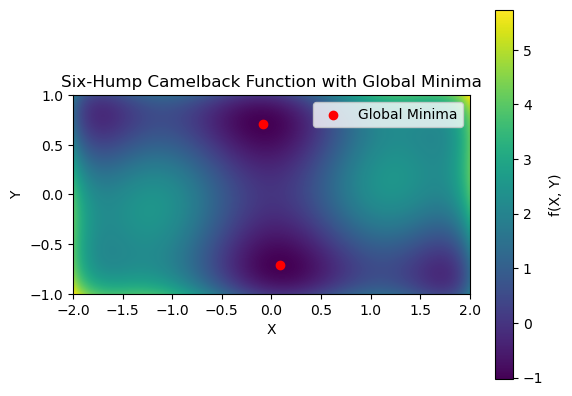

Global Minimum Point: (0.08521303258145352, -0.7085427135678393)
Function Value at Minimum: -1.0314260977136818
Global Minimum Point: (-0.08521303258145374, 0.7085427135678393)
Function Value at Minimum: -1.0314260977136818


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Definisci la funzione six-hump camelback
def six_hump_camelback(x, y):
    return (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2

# Genera una griglia di punti
x_values = np.linspace(-2, 2, 400)
y_values = np.linspace(-1, 1, 200)

# Calcola i valori della funzione sulla griglia
Z = np.zeros((len(y_values), len(x_values)))
for i, y in enumerate(y_values):
    for j, x in enumerate(x_values):
        Z[i, j] = six_hump_camelback(x, y)

# Trova i minimi della funzione sulla griglia
minima_points = np.argwhere(Z == np.min(Z))
minima_values = [Z[tuple(point)] for point in minima_points]

# Visualizza il grafico della funzione e i minimi
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis')
plt.colorbar(label='f(X, Y)')
plt.scatter(x_values[minima_points[:, 1]], y_values[minima_points[:, 0]], c='red', marker='o', label='Global Minima')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Six-Hump Camelback Function with Global Minima')
plt.legend()
plt.show()

# Stampa i minimi globali
for point, value in zip(minima_points, minima_values):
    print(f"Global Minimum Point: ({x_values[point[1]]}, {y_values[point[0]]})")
    print(f"Function Value at Minimum: {value}")
